In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving archive (1).zip to archive (1).zip
User uploaded file "archive (1).zip" with length 63252113 bytes


In [7]:
from zipfile import ZipFile
file_name = "archive (1).zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


In [8]:
import numpy as np
import cv2
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

In [9]:
from tensorflow.keras.optimizers import Adam

In [10]:
train_dir = 'train'
val_dir = 'test'
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [11]:
emotion_model = Sequential()
emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))
emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

In [12]:
emotion_model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])
emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
448/448 [==============================] - 31s 47ms/step - loss: 1.8040 - accuracy: 0.2580 - val_loss: 1.7345 - val_accuracy: 0.3224
Epoch 2/50
448/448 [==============================] - 21s 46ms/step - loss: 1.6365 - accuracy: 0.3624 - val_loss: 1.5392 - val_accuracy: 0.4184
Epoch 3/50
448/448 [==============================] - 20s 46ms/step - loss: 1.5295 - accuracy: 0.4108 - val_loss: 1.4771 - val_accuracy: 0.4300
Epoch 4/50
448/448 [==============================] - 21s 46ms/step - loss: 1.4550 - accuracy: 0.4443 - val_loss: 1.3981 - val_accuracy: 0.4752
Epoch 5/50
448/448 [==============================] - 20s 46ms/step - loss: 1.3939 - accuracy: 0.4689 - val_loss: 1.3557 - val_accuracy: 0.4933
Epoch 6/50
448/448 [==============================] - 20s 45ms/step - loss: 1.3434 - accuracy: 0.4888 - val_loss: 1.3208 - val_accuracy: 0.5049
Epoch 7/50
448/448 [==============================] - 20s 45ms/step - loss: 1.3018 - accuracy: 0.5069 - val_loss: 1.2768 - val_accuracy:

In [13]:
#Saving the model
emotion_model.save('model.h5')

In [14]:
from keras.models import load_model
emotion_model = load_model('model.h5')

In [15]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

In [16]:
#CODE for Capturing an image on Colab from here: https://colab.research.google.com/notebook#fileId=1OnUy6eFE7XhdfGfAHDCqQxpwueTOj_NO

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [46]:
take_photo()

<IPython.core.display.Javascript object>

'photo.jpg'

OpenCV(4.1.2) /io/opencv/modules/objdetect/src/cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'detectMultiScale'



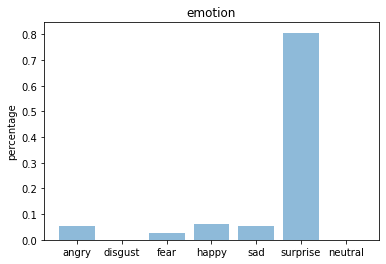

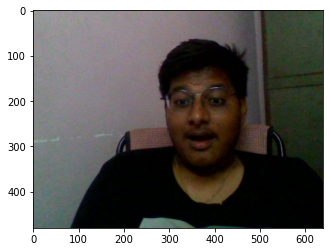

In [47]:
import cv2
            
def facecrop(image):  
    facedata = '/content/haarcascade_frontalface_alt.xml'
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)

    try:
    
        minisize = (img.shape[1],img.shape[0])
        miniframe = cv2.resize(img, minisize)

        faces = cascade.detectMultiScale(miniframe)

        for f in faces:
            x, y, w, h = [ v for v in f ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            sub_face = img[y:y+h, x:x+w]

            
            cv2.imwrite('capture.jpg', sub_face)
            #print ("Writing: " + image)

    except Exception as e:
        print (e)

   


if __name__ == '__main__':
    facecrop('/content/photo.jpg')

#Testing a file.

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


file = '/content/photo.jpg'
true_image = image.load_img(file)
img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = emotion_model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);


plt.imshow(true_image)
plt.show()